In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pandas as pd
from pylab import meshgrid
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator

# 1. Toy dataset (randomly generated from gaussian distributions)

# 1.1 One-Dimension optimization (with toy dataset)

Number of uncategorized data points = 0


/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/1932903093.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/1932903093.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/1932903093.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]


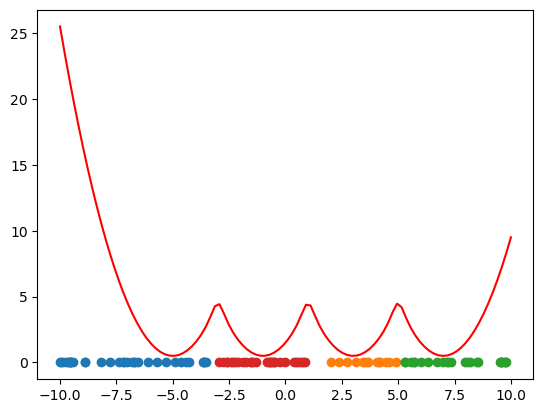

In [2]:
def potential_eqn(x, data, sigma=1):
    num=0
    denum=0
    for i in range(len(data)):
        num+=(x-data[i])**2 * np.exp(-(x-data[i])**2/sigma)
        denum+=np.exp(-(x-data[i])**2/sigma)    
    return num/denum + .5

min=[-5,3,7,-1]
sigma=1

def compute_min(init_x, method='BFGS'):
    result=minimize(potential_eqn, init_x, args=(min,sigma), method=method)
    return result['x'][0]

optimize_method='CG'
xmax=10
xmin=-10
test_pts = pd.DataFrame([random.random() * (xmax-xmin) + xmin for i in range(100)], columns=['init_x'])
test_pts['min_x']=test_pts.apply(lambda x, method=optimize_method: compute_min(x['init_x'],method), axis=1)

df_set={}
df_set['nan']=test_pts
for i in min:
    df_set[i]=test_pts[np.abs(test_pts['min_x']-i) < 0.01]
    df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]
print("Number of uncategorized data points = {}".format(len(df_set['nan'])))

# plotting
x = np.linspace(-10, 10, 100)
plt.plot(x, potential_eqn(x,min,sigma), color='red')
for idx in min:
    plt.scatter(df_set[idx]['init_x'].to_numpy(), [0 for i in range(len(df_set[idx]))])
plt.scatter(df_set['nan']['init_x'].to_numpy(), [0 for i in range(len(df_set['nan']))])
plt.show()


# 1.2 Two-Dimension optimization (with toy dataset)

In [3]:
def potential_eqn(xs, data, sigma=1):
    num=0
    denum=0
    for i in range(len(data)):
        dist=np.linalg.norm(xs-data[i])
        num+=dist**2 * np.exp(-dist**2/sigma)
        denum+=np.exp(-dist**2/sigma)
    return num/denum

def compute_min(init_x, data, sigma, method='BFGS'):
    if method=='Newton-CG':
        fprime = lambda x: optimize.approx_fprime(x, potential_eqn, 0.01)
        result=minimize(potential_eqn, init_x, args=(data,sigma), method=method, jac=fprime)
    else:
        result=minimize(potential_eqn, init_x, args=(data,sigma), method=method)
    return result['x']

### Creating toy experiment 

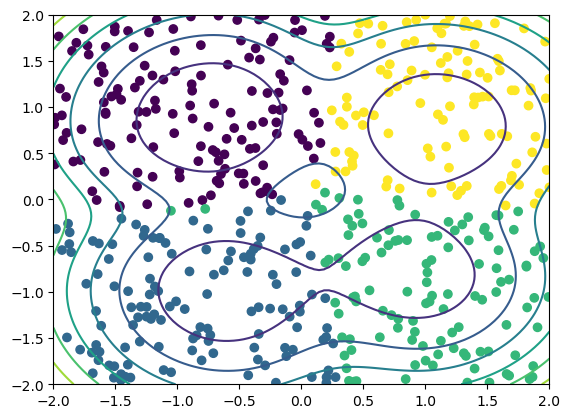

In [4]:
# defining toy model
num_testpts=500
min=[np.array([1,0.7]),np.array([-0.5,-0.9]),np.array([-0.65,0.8]),np.array([0.8,-0.7])]

# setting minimization config
my_sigma=0.7
my_method='CG'
xmax=2
xmin=-2

# creating test points 
test_pts = pd.DataFrame({'init_f1': [random.random() * (xmax-xmin) + xmin for i in range(num_testpts)], 'init_f2': [random.random() * (xmax-xmin) + xmin for i in range(num_testpts)]})
# computing the minima they belong to 
ans=test_pts.apply(lambda x: compute_min([x['init_f1'],x['init_f2']],min,my_sigma,my_method), axis=1)
for i in range(len(ans[0])):
    test_pts['min_f{}'.format(i+1)]=ans.str[i]

# creating labels based on the minima the data point belongs to
test_pts=test_pts.sort_values(by=['min_f1','min_f2']) # sort and scan through the list; set new label if the next point is different
tmp_f1=float('nan')
tmp_f2=float('nan')
set_tmp=True
tmp_label=0
list_label=[]
for index, row in test_pts.iterrows():
    if(set_tmp==True):
        tmp_f1=row['min_f1']
        tmp_f2=row['min_f2']
        set_tmp=False
    dist=np.linalg.norm(np.array(row['min_f1'],row['min_f2'])-np.array(tmp_f1,tmp_f2))
    if(dist<0.02):
        list_label.append(tmp_label)
    else:
        tmp_label+=1
        list_label.append(tmp_label)
        tmp_f1=row['min_f1']
        tmp_f2=row['min_f2']    

# plotting
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X,Y = meshgrid(x, y)
Z = np.array([[potential_eqn(np.array([i,j]), min, my_sigma) for i in x] for j in y])

fig, ax = plt.subplots(1, 1) 
ax.contour(X, Y, Z) 
plt.scatter(test_pts['init_f1'].to_numpy(), test_pts['init_f2'].to_numpy(), c=list_label)
plt.show()

# 2. Proof-of-concept with Crab dataset 
link to dataset: https://www.stats.ox.ac.uk/pub/PRNN/crabs.dat


# 2.1 Reading data

In [5]:
df_crabs = pd.read_table("crabs.dat", sep="\s+", usecols=[0,1,3,4,5,6,7], skiprows=1, names=['sp', 'sex', 'FL', 'RW', 'CL', 'CW', 'BD'])
df_crabs['true_label']=(df_crabs['sp']=='O')*2+(df_crabs['sex']=='F')
print(df_crabs)

    sp sex    FL    RW    CL    CW    BD  true_label
0    B   M   8.1   6.7  16.1  19.0   7.0           0
1    B   M   8.8   7.7  18.1  20.8   7.4           0
2    B   M   9.2   7.8  19.0  22.4   7.7           0
3    B   M   9.6   7.9  20.1  23.1   8.2           0
4    B   M   9.8   8.0  20.3  23.0   8.2           0
..  ..  ..   ...   ...   ...   ...   ...         ...
195  O   F  21.4  18.0  41.2  46.2  18.7           3
196  O   F  21.7  17.1  41.7  47.2  19.6           3
197  O   F  21.9  17.2  42.6  47.4  19.5           3
198  O   F  22.5  17.2  43.0  48.7  19.8           3
199  O   F  23.1  20.2  46.2  52.5  21.1           3

[200 rows x 8 columns]


In [6]:
## Uncomment to plotting the raw features, which are terrible for clustering
# for f1 in ['FL', 'RW', 'CL', 'CW', 'BD']:
#     for f2 in ['FL', 'RW', 'CL', 'CW', 'BD']:
#         plt.show(plt.scatter(df_crabs[f1],df_crabs[f2], c=df_crabs['true_label']))

In [7]:
df_crabs[['FL', 'RW', 'CL', 'CW', 'BD']]

,FL,RW,CL,CW,BD
0,8.1,6.7,16.1,19.0,7.0
1,8.8,7.7,18.1,20.8,7.4
2,9.2,7.8,19.0,22.4,7.7
3,9.6,7.9,20.1,23.1,8.2
4,9.8,8.0,20.3,23.0,8.2
...,...,...,...,...,...
195,21.4,18.0,41.2,46.2,18.7
196,21.7,17.1,41.7,47.2,19.6
197,21.9,17.2,42.6,47.4,19.5
198,22.5,17.2,43.0,48.7,19.8


# 2.2 Pre-processing with PCA & UMAP 

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_crabs[['FL', 'RW', 'CL', 'CW', 'BD']])


    sp sex    FL    RW    CL    CW    BD  true_label     umap_0    umap_1  \
0    B   M   8.1   6.7  16.1  19.0   7.0           0   8.639093  7.890339   
1    B   M   8.8   7.7  18.1  20.8   7.4           0   8.427420  7.800413   
2    B   M   9.2   7.8  19.0  22.4   7.7           0   8.434503  7.790866   
3    B   M   9.6   7.9  20.1  23.1   8.2           0   8.686875  7.958227   
4    B   M   9.8   8.0  20.3  23.0   8.2           0   8.848148  7.925905   
..  ..  ..   ...   ...   ...   ...   ...         ...        ...       ...   
195  O   F  21.4  18.0  41.2  46.2  18.7           3  17.690710  2.530016   
196  O   F  21.7  17.1  41.7  47.2  19.6           3  17.898491  2.355664   
197  O   F  21.9  17.2  42.6  47.4  19.5           3  17.913988  2.340162   
198  O   F  22.5  17.2  43.0  48.7  19.8           3  18.063547  2.218678   
199  O   F  23.1  20.2  46.2  52.5  21.1           3  18.031139  2.233675   

       umap_2     umap_3     pca_0     pca_1     pca_2     pca_3  
0    3.4

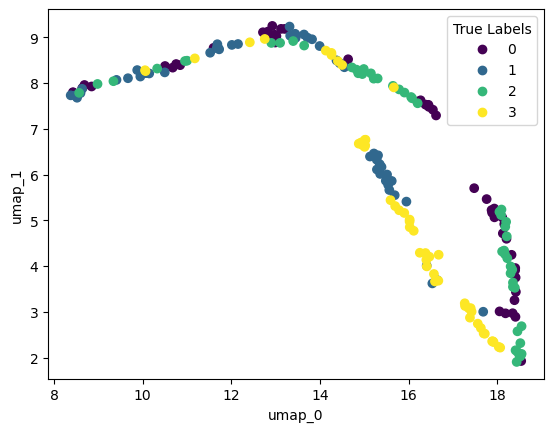

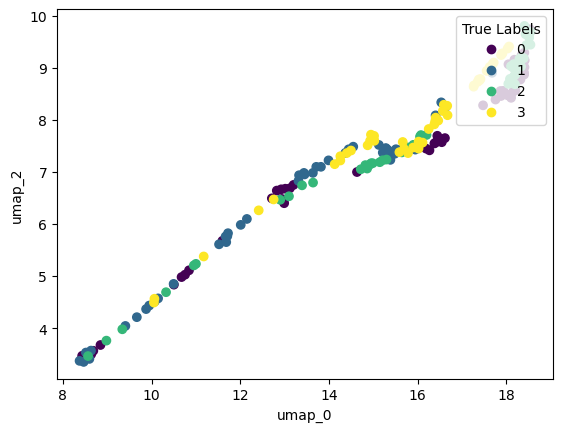

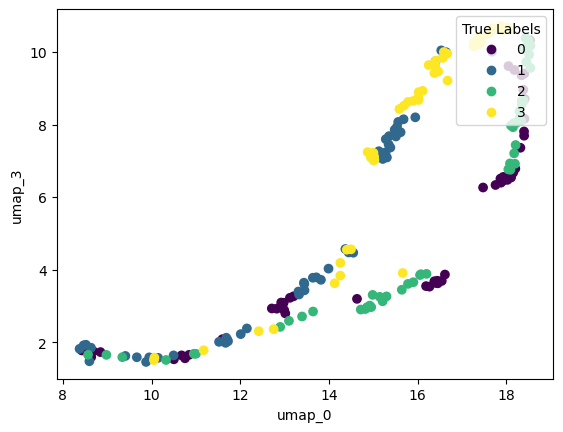

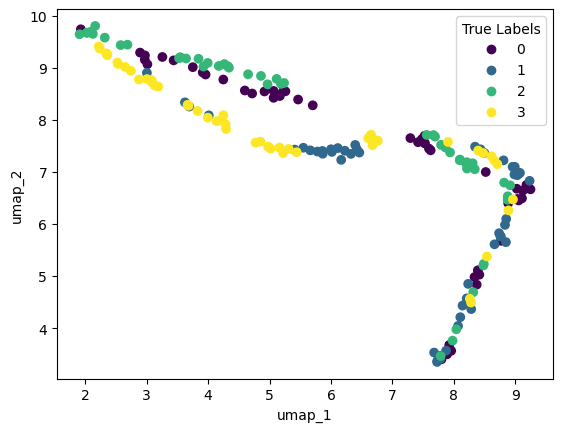

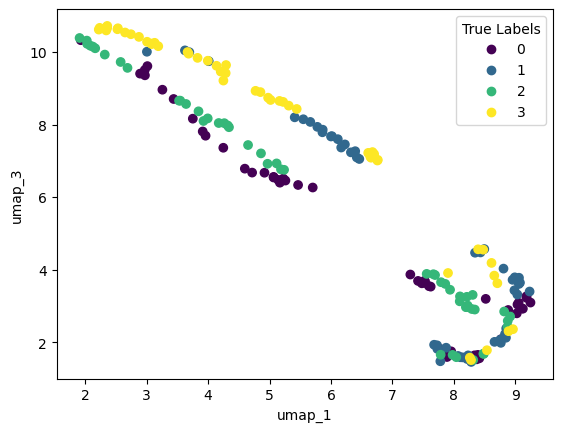

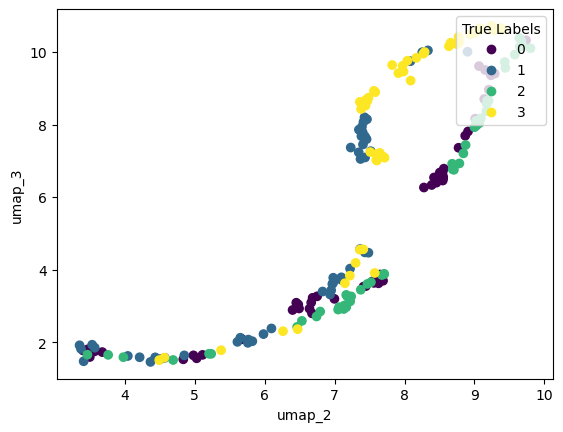

In [22]:
# Using U-MAP to get two projected features for clustering test
reducer = umap.UMAP(n_components=df_crabs['true_label'].nunique()) #VGG adjust the components
embedding = reducer.fit_transform(scaled_features)
# print(embedding.shape)
for i in range(embedding.shape[1]):
    df_crabs["umap_{}".format(i)]=embedding[:, i]
print(df_crabs)

for i in range(embedding.shape[1]):
    for j in range(i+1,embedding.shape[1]):
        scatter=plt.scatter(embedding[:, i],embedding[:, j], c=df_crabs['true_label'])
        plt.xlabel("umap_{}".format(i))
        plt.ylabel("umap_{}".format(j))
        plt.legend(*scatter.legend_elements(), loc="upper right", title="True Labels")
        plt.savefig(f"results/crab_umap{i}_vs_umap{j}.pdf")
        plt.show()


    sp sex    FL    RW    CL    CW    BD  true_label     umap_0    umap_1  \
0    B   M   8.1   6.7  16.1  19.0   7.0           0   8.639093  7.890339   
1    B   M   8.8   7.7  18.1  20.8   7.4           0   8.427420  7.800413   
2    B   M   9.2   7.8  19.0  22.4   7.7           0   8.434503  7.790866   
3    B   M   9.6   7.9  20.1  23.1   8.2           0   8.686875  7.958227   
4    B   M   9.8   8.0  20.3  23.0   8.2           0   8.848148  7.925905   
..  ..  ..   ...   ...   ...   ...   ...         ...        ...       ...   
195  O   F  21.4  18.0  41.2  46.2  18.7           3  17.690710  2.530016   
196  O   F  21.7  17.1  41.7  47.2  19.6           3  17.898491  2.355664   
197  O   F  21.9  17.2  42.6  47.4  19.5           3  17.913988  2.340162   
198  O   F  22.5  17.2  43.0  48.7  19.8           3  18.063547  2.218678   
199  O   F  23.1  20.2  46.2  52.5  21.1           3  18.031139  2.233675   

       umap_2     umap_3     pca_0     pca_1     pca_2     pca_3  
0    3.4

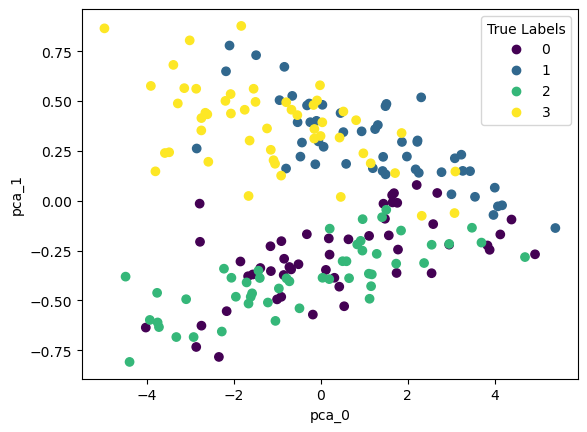

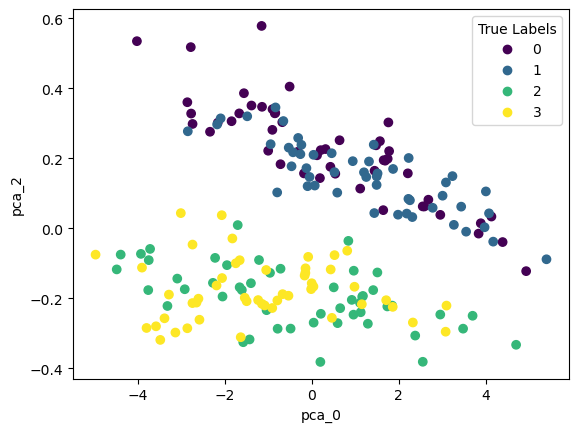

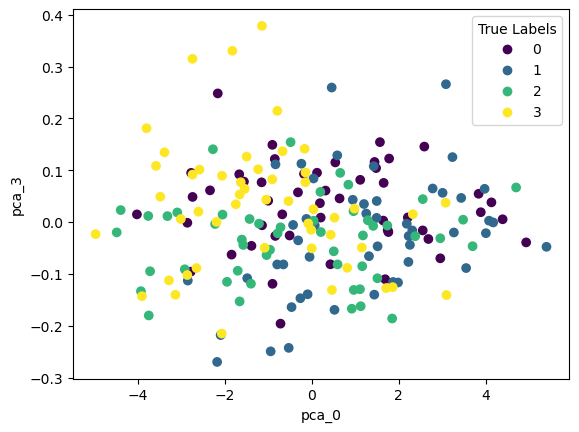

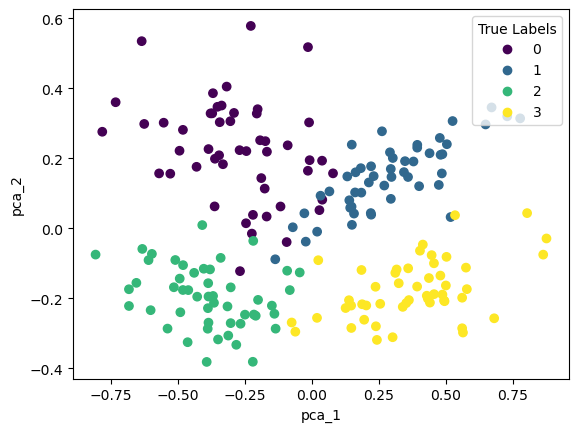

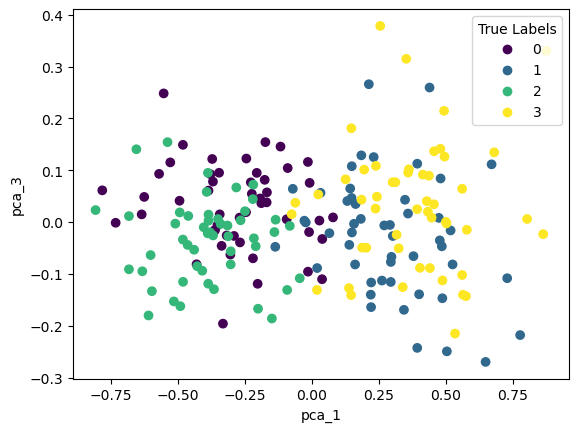

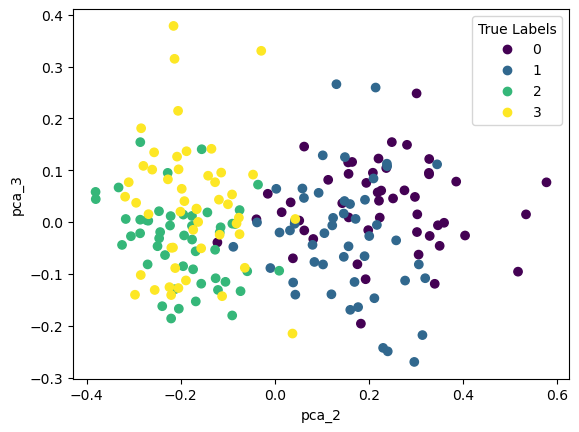

In [23]:
# Using PCA to get two projected features for clustering test
pca = PCA(n_components=df_crabs['true_label'].nunique()) 
features_pca = pca.fit_transform(scaled_features)
# pca.n_components_
# print(features_pca.shape)
for i in range(pca.n_components_):
    df_crabs["pca_{}".format(i)]=features_pca[:, i]
print(df_crabs)

for i in range(pca.n_components_):
    for j in range(i+1,pca.n_components_):
        scatter=plt.scatter(features_pca[:, i],features_pca[:, j], c=df_crabs['true_label'])
        plt.xlabel("pca_{}".format(i))
        plt.ylabel("pca_{}".format(j))
        plt.legend(*scatter.legend_elements(), loc="upper right", title="True Labels")
        plt.savefig(f"results/crab_pca{i}_vs_pca{j}.pdf")
        plt.show()


# 2.3 Applying quantum clustering

In [11]:
# Set the choice of components for the clustering 2-d plane
component_for_x=1
component_for_y=2

my_sigma=0.06
my_method='BFGS'

df_copy_crabs=df_crabs.copy()
ans=df_copy_crabs.apply(lambda x: compute_min([x['pca_{}'.format(component_for_x)],x['pca_{}'.format(component_for_y)]],df_copy_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y)]].to_numpy(),my_sigma,my_method), axis=1)
for i in range(len(ans[0])):
    df_copy_crabs['min_f{}'.format(i+1)]=ans.str[i]

print(df_copy_crabs)

    sp sex    FL    RW    CL    CW    BD  true_label     umap_0    umap_1  \
0    B   M   8.1   6.7  16.1  19.0   7.0           0   3.750995  9.582180   
1    B   M   8.8   7.7  18.1  20.8   7.4           0   3.661466  9.519276   
2    B   M   9.2   7.8  19.0  22.4   7.7           0   3.780162  9.292560   
3    B   M   9.6   7.9  20.1  23.1   8.2           0   3.758631  9.182733   
4    B   M   9.8   8.0  20.3  23.0   8.2           0   3.879237  9.052254   
..  ..  ..   ...   ...   ...   ...   ...         ...        ...       ...   
195  O   F  21.4  18.0  41.2  46.2  18.7           3  15.866034 -1.726207   
196  O   F  21.7  17.1  41.7  47.2  19.6           3  15.777245 -1.891440   
197  O   F  21.9  17.2  42.6  47.4  19.5           3  15.728071 -1.988345   
198  O   F  22.5  17.2  43.0  48.7  19.8           3  15.625495 -2.080548   
199  O   F  23.1  20.2  46.2  52.5  21.1           3  15.708657 -2.183401   

       umap_2    umap_3     pca_0     pca_1     pca_2     pca_3    min_f1  

In [12]:
# creating labels based on the minima the data point belongs to
df_copy_crabs=df_copy_crabs.sort_values(by=['min_f1','min_f2']) # sort and scan through the list; set new label if the next point is different
tmp_f1=float('nan')
tmp_f2=float('nan')
set_tmp=True
tmp_label=0
crab_label=[]
for index, row in df_copy_crabs.iterrows():
    if(set_tmp==True):
        tmp_f1=row['min_f1']
        tmp_f2=row['min_f2']
        set_tmp=False
    
    dist=np.linalg.norm(np.array([row['min_f1'],row['min_f2']])-np.array([tmp_f1,tmp_f2]))
    if(dist<0.02):
        crab_label.append(tmp_label)
    else:
        tmp_label+=1
        crab_label.append(tmp_label)
        tmp_f1=row['min_f1']
        tmp_f2=row['min_f2']    
df_copy_crabs['recon_label']=crab_label



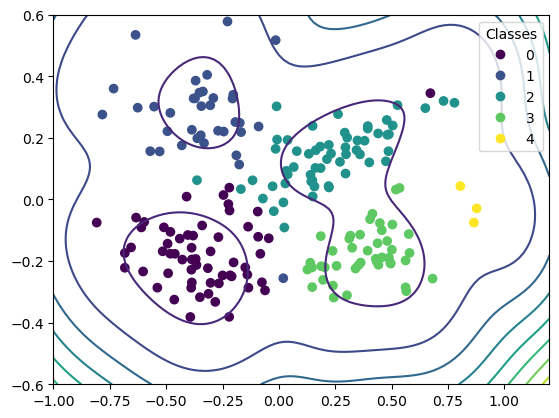

In [13]:
# plotting
x = np.linspace(-1, 1.2, 100)
y = np.linspace(-0.6, 0.6, 100)
X,Y = meshgrid(x, y)
Z = np.array([[potential_eqn(np.array([i,j]), df_copy_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y)]].to_numpy(), my_sigma) for i in x] for j in y])

fig, ax = plt.subplots(1, 1) 
ax.contour(X, Y, Z) 
scatter = ax.scatter(df_copy_crabs['pca_{}'.format(component_for_x)].to_numpy(), df_copy_crabs['pca_{}'.format(component_for_y)].to_numpy(), c=df_copy_crabs['recon_label'].to_list())
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
plt.show()

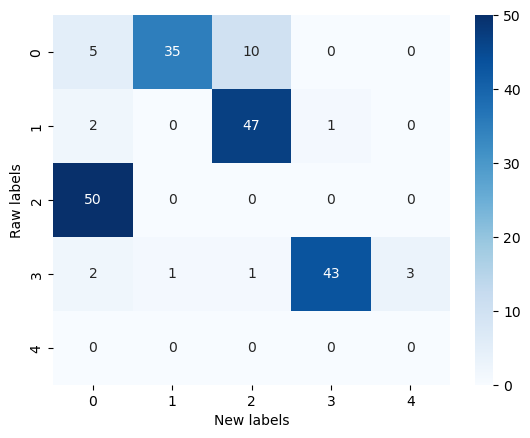

In [14]:
cf_matrix = confusion_matrix(df_copy_crabs['true_label'], df_copy_crabs['recon_label'])
ax= plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True)
ax.set_xlabel('New labels');ax.set_ylabel('Raw labels'); 

# 2.3.1 Investigation of wrongly labeled data points

In [15]:
# Choose the confusion matrix bin to plot
raw_label_idx=0
new_label_idx=2

df_target_crabs=df_copy_crabs[(df_copy_crabs['true_label']==raw_label_idx) & (df_copy_crabs['recon_label']==new_label_idx)]
df_other_crabs=df_copy_crabs[(df_copy_crabs['true_label']!=raw_label_idx) | (df_copy_crabs['recon_label']!=new_label_idx)]


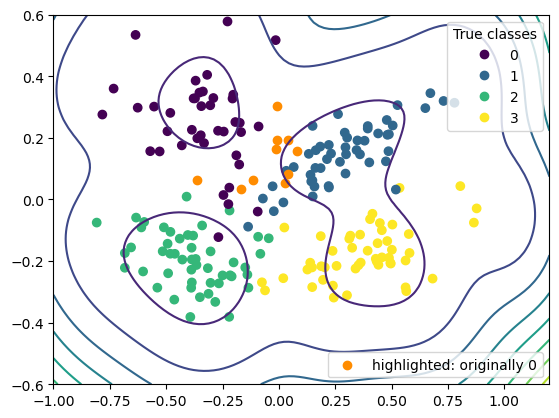

In [16]:
# plotting
fig, ax = plt.subplots(1, 1) 
ax.contour(X, Y, Z) 
scatter = ax.scatter(df_other_crabs['pca_{}'.format(component_for_x)].to_numpy(), df_other_crabs['pca_{}'.format(component_for_y)].to_numpy(), c=df_other_crabs['true_label'].to_list())
myscatter = ax.scatter(df_target_crabs['pca_{}'.format(component_for_x)].to_numpy(), df_target_crabs['pca_{}'.format(component_for_y)].to_numpy(),color='darkorange')
leg1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="True classes")
ax.add_artist(leg1)
ax.legend([myscatter], [f"highlighted: originally {raw_label_idx}"], loc="lower right")
plt.show()

# 2.4. Study of dependence of category groups as a function of sigma

In [24]:
component_for_x=1
component_for_y=2

# list_method=['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP',
#              'trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']
list_method=['SLSQP','L-BFGS-B','COBYLA','Nelder-Mead','CG','BFGS']
# list_method=['BFGS']
list_sigma=np.arange(0.002, 0.16, 0.002)

list_numCat={}

for my_method in tqdm(list_method):
    list_numCat[my_method]=[]
    for my_sigma in tqdm(list_sigma):
        # run the quantum clustering
        df_copy_crabs=df_crabs.copy()
        ans=df_copy_crabs.apply(lambda x: compute_min([x['pca_{}'.format(component_for_x)],x['pca_{}'.format(component_for_y)]],df_copy_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y)]].to_numpy(),my_sigma,my_method), axis=1)
        for i in range(len(ans[0])):
            df_copy_crabs['min_f{}'.format(i+1)]=ans.str[i]
    #     print(df_copy_crabs)

        # using DBSCAN to find the number of clusters
        X_train = df_copy_crabs[['min_f1', 'min_f2']]
        clustering = DBSCAN(eps=0.02, min_samples=3).fit(X_train)
        DBSCAN_dataset = X_train.copy()
        DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 
        num_class=0
        for icat,cnt in zip(DBSCAN_dataset.Cluster.value_counts().index,DBSCAN_dataset.Cluster.value_counts().values):
            if(int(icat)!=-1):
                num_class+=1
            else:
                num_class+=cnt
        list_numCat[my_method].append(num_class)

  0%|                                                                                                              | 0/79 [00:00<?, ?it/s]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

  1%|█▎                                                           


 11%|███████████▌                                                                                          | 9/79 [00:24<03:25,  2.94s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 13%|████████████▊                                               

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 41%|████████████████████████████████████████▉                                                            | 32/79 [01:29<02:06,  2.70s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 42%|██████████████████████████████████████████▏                                                          | 33/79 [01:32<02:00,  2.62s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: Runti

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 62%|██████████████████████████████████████████████████████████████▋                                      | 49/79 [02:13<01:28,  2.94s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/4

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 66%|██████████████████████████████████████████████████████████████████▍                                  | 52/79 [02:24<01:33,  3.46s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/4


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 61/79 [02:54<00:59,  3.32s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/4


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 65/79 [03:07<00:46,  3.29s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/4

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

  4%|███▊                                                                                                  | 3/79 [00:13<06:01,  4.75s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/4


 19%|███████████████████▏                                                                                 | 15/79 [01:10<04:54,  4.61s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 20%|████████████████████▍                                                                                | 16/79 [01:14<04:49,  4.59s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 22%|█████████████████████▋                                                          

 18%|█████████████████▉                                                                                   | 14/79 [01:43<08:35,  7.93s/it]


  3%|██▌                                                                                                   | 2/79 [00:09<05:50,  4.56s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 14%|██████████████                                                                                       | 11/79 [00:56<05:58,  5.27s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: Runtim

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 58/79 [05:05<01:58,  5.62s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 59/79 [05:11<01:54,  5.71s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: Runtim

 29%|█████████████████████████████▍                                                                       | 23/79 [01:30<03:23,  3.64s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 60/79 [03:43<01:13,  3.89s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: Runtim

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn

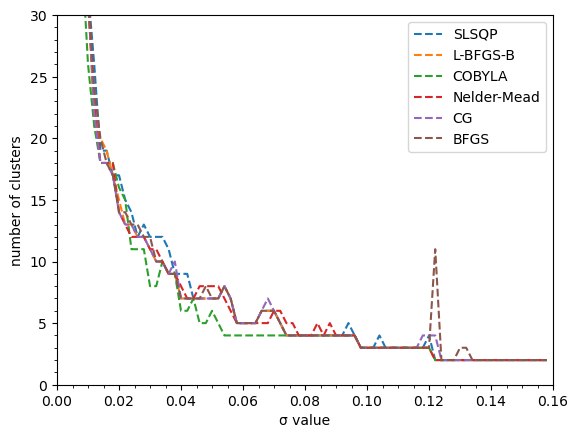

In [26]:
for my_method in list_method: # list_method=['SLSQP','L-BFGS-B','COBYLA','Nelder-Mead','CG','BFGS']
    plt.plot(list_sigma, list_numCat[my_method], '--', label=my_method)     
plt.xlabel("σ value".format(i))
plt.ylabel("number of clusters".format(j))
plt.xlim(0,0.16)
plt.ylim(0,30)
plt.minorticks_on()
plt.legend(loc='best')
plt.savefig(f"results/crab_numClusters_vs_sigma_pca{component_for_x}-pca{component_for_y}.pdf")
plt.show() 

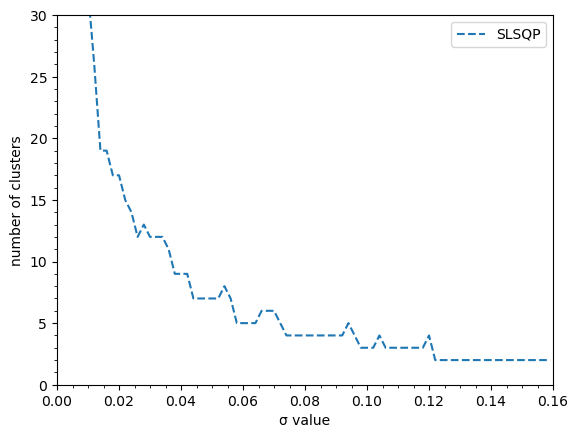

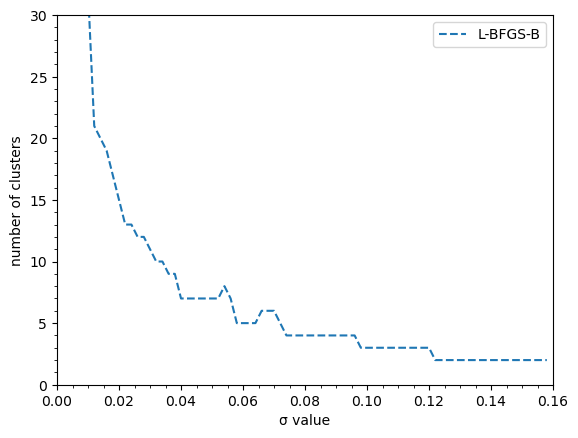

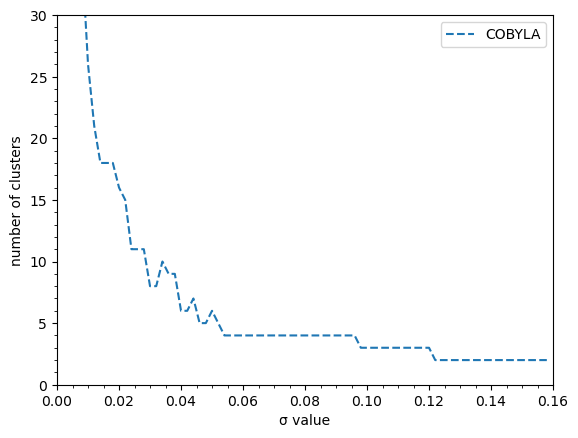

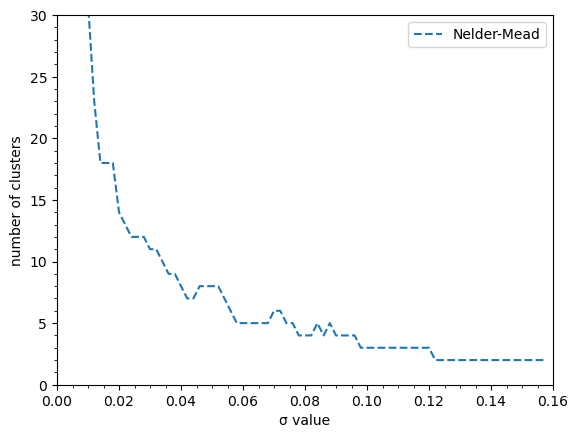

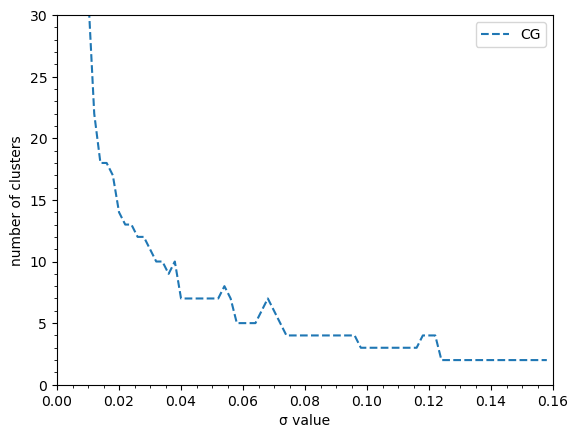

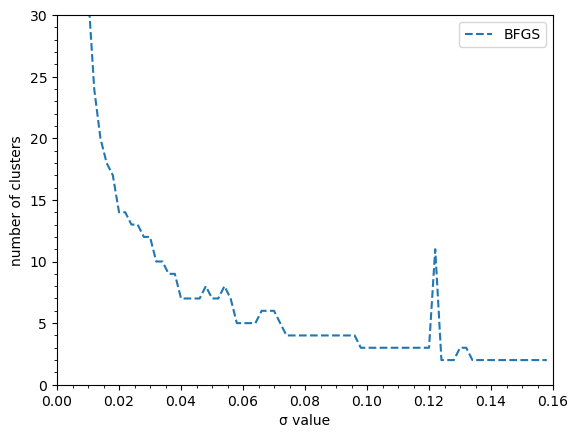

In [27]:
for my_method in list_method: # list_method=['SLSQP','L-BFGS-B','COBYLA','Nelder-Mead','CG','BFGS']
    plt.plot(list_sigma, list_numCat[my_method], '--', label=my_method)     
    plt.xlabel("σ value".format(i))
    plt.ylabel("number of clusters".format(j))
    plt.xlim(0,0.16)
    plt.ylim(0,30)
    plt.minorticks_on()
    plt.legend(loc='best')
    plt.savefig(f"results/crab_numClusters_vs_sigma_{my_method}_pca{component_for_x}-pca{component_for_y}.pdf")
    plt.show() 


# 2.4.1 more detail study with promising working point

In [54]:
component_for_x=1
component_for_y=2

my_method='CG' # COBYLA / BFGS / CG
my_sigma=0.08

# run the quantum clustering
df_copy_crabs=df_crabs.copy()
ans=df_copy_crabs.apply(lambda x: compute_min([x['pca_{}'.format(component_for_x)],x['pca_{}'.format(component_for_y)]],df_copy_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y)]].to_numpy(),my_sigma,my_method), axis=1)
for i in range(len(ans[0])):
    df_copy_crabs['min_f{}'.format(i+1)]=ans.str[i]

# using DBSCAN to find cluster labelling
X_train = df_copy_crabs[['min_f1', 'min_f2']]
clustering = DBSCAN(eps=0.02, min_samples=3).fit(X_train)
df_copy_crabs['recon_label']=clustering.labels_

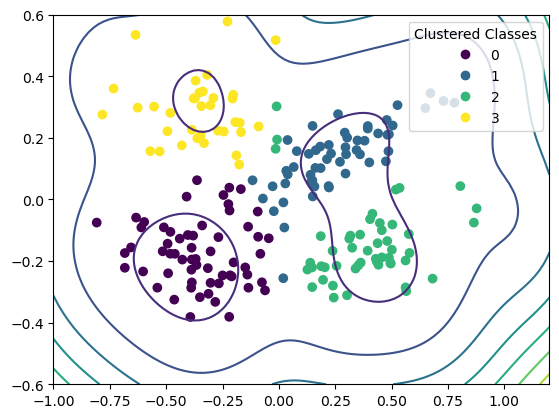

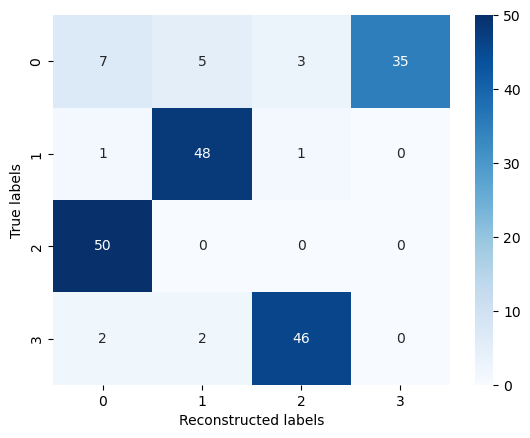

In [55]:
# plotting
x = np.linspace(-1, 1.2, 100)
y = np.linspace(-0.6, 0.6, 100)
X,Y = meshgrid(x, y)
Z = np.array([[potential_eqn(np.array([i,j]), df_copy_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y)]].to_numpy(), my_sigma) for i in x] for j in y])

fig, ax = plt.subplots(1, 1) 
ax.contour(X, Y, Z) 
scatter = ax.scatter(df_copy_crabs['pca_{}'.format(component_for_x)].to_numpy(), df_copy_crabs['pca_{}'.format(component_for_y)].to_numpy(), c=df_copy_crabs['recon_label'].to_list())
ax.legend(*scatter.legend_elements(), loc="upper right", title="Clustered Classes")
plt.savefig(f"results/crab_clustering-result_{my_method}_sigma{my_sigma}_pca{component_for_x}-pca{component_for_y}.pdf")
plt.show()

cf_matrix = confusion_matrix(df_copy_crabs['true_label'], df_copy_crabs['recon_label'])
ax= plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True)
ax.set_xlabel('Reconstructed labels')
ax.set_ylabel('True labels')
plt.savefig(f"results/crab_confusion-matrix_{my_method}_sigma{my_sigma}_pca{component_for_x}-pca{component_for_y}.pdf")
plt.show()

# 2.5 quantum clustering with PCA in three-dimension

In [60]:
# Set the choice of components for the clustering 2-d plane
component_for_x=1
component_for_y=2
component_for_z=3

my_sigma=0.08
my_method='BFGS'

df_copy_crabs=df_crabs.copy()
ans=df_copy_crabs.apply(lambda x: compute_min([x['pca_{}'.format(component_for_x)],x['pca_{}'.format(component_for_y)],x['pca_{}'.format(component_for_z)]],df_copy_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y), 'pca_{}'.format(component_for_z)]].to_numpy(),my_sigma,my_method), axis=1)
for i in range(len(ans[0])):
    df_copy_crabs['min_f{}'.format(i+1)]=ans.str[i]

print(df_copy_crabs)

    sp sex    FL    RW    CL    CW    BD  true_label     umap_0    umap_1  \
0    B   M   8.1   6.7  16.1  19.0   7.0           0   8.639093  7.890339   
1    B   M   8.8   7.7  18.1  20.8   7.4           0   8.427420  7.800413   
2    B   M   9.2   7.8  19.0  22.4   7.7           0   8.434503  7.790866   
3    B   M   9.6   7.9  20.1  23.1   8.2           0   8.686875  7.958227   
4    B   M   9.8   8.0  20.3  23.0   8.2           0   8.848148  7.925905   
..  ..  ..   ...   ...   ...   ...   ...         ...        ...       ...   
195  O   F  21.4  18.0  41.2  46.2  18.7           3  17.690710  2.530016   
196  O   F  21.7  17.1  41.7  47.2  19.6           3  17.898491  2.355664   
197  O   F  21.9  17.2  42.6  47.4  19.5           3  17.913988  2.340162   
198  O   F  22.5  17.2  43.0  48.7  19.8           3  18.063547  2.218678   
199  O   F  23.1  20.2  46.2  52.5  21.1           3  18.031139  2.233675   

       umap_2     umap_3     pca_0     pca_1     pca_2     pca_3    min_f1 

In [61]:
# using DBSCAN to find cluster labelling
X_train = df_copy_crabs[['min_f1', 'min_f2', 'min_f3']]
clustering = DBSCAN(eps=0.02, min_samples=3).fit(X_train)
df_copy_crabs['recon_label']=clustering.labels_

In [62]:
# plotting
# x = np.linspace(-1, 1.2, 100)
# y = np.linspace(-0.6, 0.6, 100)
# z = np.linspace(-0.3, 0.4, 100)
# X,Y,Z = meshgrid(x, y, z)
# V = np.array([[[potential_eqn(np.array([i,j,k]), df_copy_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y), 'pca_{}'.format(component_for_z)]].to_numpy(), my_sigma) for i in x] for j in y] for k in z])

# fig, ax = plt.subplots(1, 1) 
# ax.contour(X, Y, V) 
# scatter = ax.scatter(df_copy_crabs['pca_{}'.format(component_for_x)].to_numpy(), df_copy_crabs['pca_{}'.format(component_for_y)].to_numpy(), c=df_copy_crabs['recon_label'].to_list())
# ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
# plt.show()

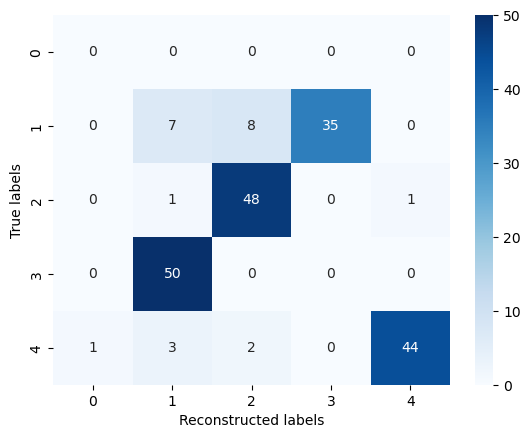

In [63]:
cf_matrix = confusion_matrix(df_copy_crabs['true_label'], df_copy_crabs['recon_label'])
ax= plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True)
ax.set_xlabel('Reconstructed labels')
ax.set_ylabel('True labels')
plt.savefig(f"results/crab_confusion-matrix_{my_method}_sigma{my_sigma}_pca{component_for_x}-pca{component_for_y}-pca{component_for_z}.pdf")
plt.show()

# 3. Kaggle cancer data (malignant vs benign)

## 3.1 Reading data

In [80]:
df_cancer = pd.read_csv("breast-cancer.csv", sep=",", header=0)
df_cancer['true_label']=df_cancer['diagnosis']=='M'
print(df_cancer)

           id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compa

In [81]:
features=['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cancer[features])


## 3.2 (a) Pre-processing with UMAP

           id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compa

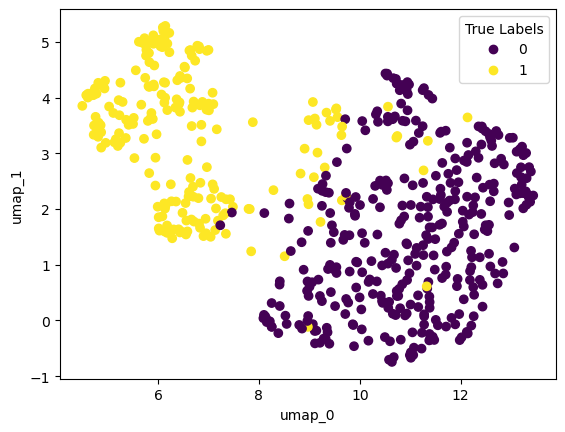

In [82]:
# Using U-MAP to get two projected features for clustering test
reducer = umap.UMAP(n_components=df_cancer['true_label'].nunique()) #VGG adjust the components
embedding = reducer.fit_transform(scaled_features)
# print(embedding.shape)
for i in range(embedding.shape[1]):
    df_cancer["umap_{}".format(i)]=embedding[:, i]
print(df_cancer)

for i in range(embedding.shape[1]):
    for j in range(i+1,embedding.shape[1]):
        scatter=plt.scatter(embedding[:, i],embedding[:, j], c=df_cancer['true_label'])
        plt.xlabel("umap_{}".format(i))
        plt.ylabel("umap_{}".format(j))
        plt.legend(*scatter.legend_elements(), loc="upper right", title="True Labels")
        plt.savefig(f"results/kaggle-cancer_umap{i}_vs_umap{j}.pdf")
        plt.show()



## 3.2 (b) Pre-processing with PCA

           id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compa

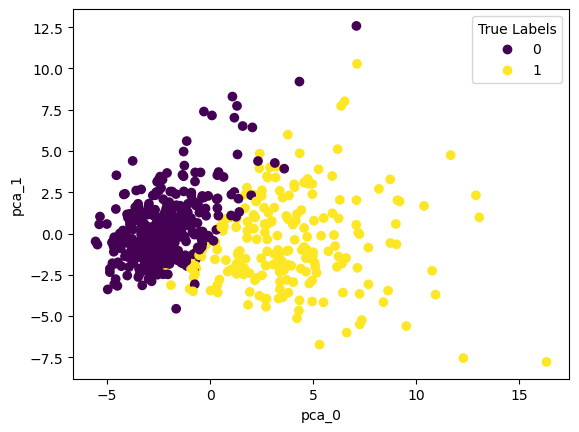

In [83]:
# Using PCA to get two projected features for clustering test
pca = PCA(n_components=df_cancer['true_label'].nunique()) 
features_pca = pca.fit_transform(scaled_features)
# pca.n_components_
# print(features_pca.shape)
for i in range(pca.n_components_):
    df_cancer["pca_{}".format(i)]=features_pca[:, i]
print(df_cancer)

for i in range(pca.n_components_):
    for j in range(i+1,pca.n_components_):
        scatter=plt.scatter(features_pca[:, i],features_pca[:, j], c=df_cancer['true_label'])
        plt.xlabel("pca_{}".format(i))
        plt.ylabel("pca_{}".format(j))
        plt.legend(*scatter.legend_elements(),loc="upper right", title="True Labels")
        plt.savefig(f"results/kaggle-cancer_pca{i}_vs_pca{j}.pdf")
        plt.show()


## 3.3 Studying number of clusters as a function of sigma value (post-UMAP) 

In [86]:
# Set the choice of components for the clustering 2-d plane
component_for_x=0
component_for_y=1

# list_method=['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP',
#              'trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']
# list_method=['BFGS']
list_method=['SLSQP','L-BFGS-B','COBYLA','Nelder-Mead','CG','BFGS']
list_sigma=np.arange(0.2, 10.0, 0.2)

list_numCat={}

for my_method in tqdm(list_method):
    list_numCat[my_method]=[]
    for my_sigma in tqdm(list_sigma):
        # run the quantum clustering
        df_copy_cancer=df_cancer.copy()
        ans=df_copy_cancer.apply(lambda x: compute_min([x['umap_{}'.format(component_for_x)],x['umap_{}'.format(component_for_y)]],df_copy_cancer[['umap_{}'.format(component_for_x), 'umap_{}'.format(component_for_y)]].to_numpy(),my_sigma,my_method), axis=1)
        for i in range(len(ans[0])):
            df_copy_cancer['min_f{}'.format(i+1)]=ans.str[i]
    #     print(df_copy_cancer)

        # using DBSCAN to find the number of clusters
        X_train = df_copy_cancer[['min_f1', 'min_f2']]
        clustering = DBSCAN(eps=1.0, min_samples=3).fit(X_train)
        DBSCAN_dataset = X_train.copy()
        DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 
        num_class=0
        for icat,cnt in zip(DBSCAN_dataset.Cluster.value_counts().index,DBSCAN_dataset.Cluster.value_counts().values):
            if(int(icat)!=-1):
                num_class+=1
            else:
                num_class+=cnt
        list_numCat[my_method].append(num_class)

  0%|                                                                                                              | 0/49 [00:00<?, ?it/s]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/48

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 29%|████████████████████████████▊                                                                        | 14/49 [06:22<15:44, 26.98s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/4

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn


  4%|████▏                                                                                                 | 2/49 [01:19<30:58, 39.54s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

  6%|██████▏                                                     

  0%|                                                                                                              | 0/49 [00:00<?, ?it/s]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/48

 49%|█████████████████████████████████████████████████▍                                                   | 24/49 [21:17<26:47, 64.30s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 46/49 [38:21<02:15, 45.04s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: Runtim

/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum

 10%|██████████▍                                                                                           | 5/49 [03:05<26:09, 35.67s/it]/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/489070469.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return num/denum
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_85640/4

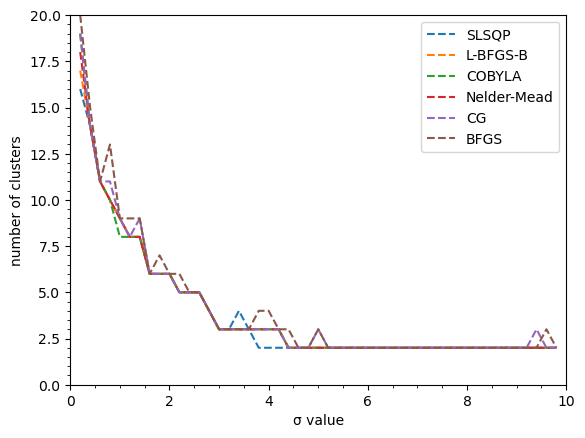

In [89]:
for my_method in list_method: # list_method=['SLSQP','L-BFGS-B','COBYLA','Nelder-Mead','CG','BFGS']
    plt.plot(list_sigma, list_numCat[my_method], '--', label=my_method)     
plt.xlabel("σ value".format(i))
plt.ylabel("number of clusters".format(j))
plt.xlim(0,10)
plt.ylim(0,20)
plt.minorticks_on()
plt.legend(loc='best')
plt.savefig(f"results/kaggle-cancer_numClusters_vs_sigma_All-methods_umap{component_for_x}-umap{component_for_y}.pdf")
plt.show() 

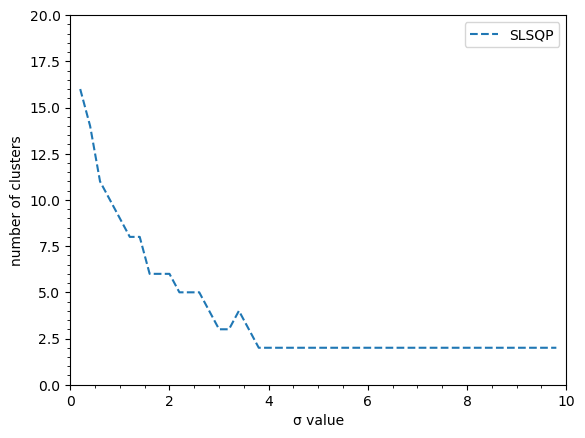

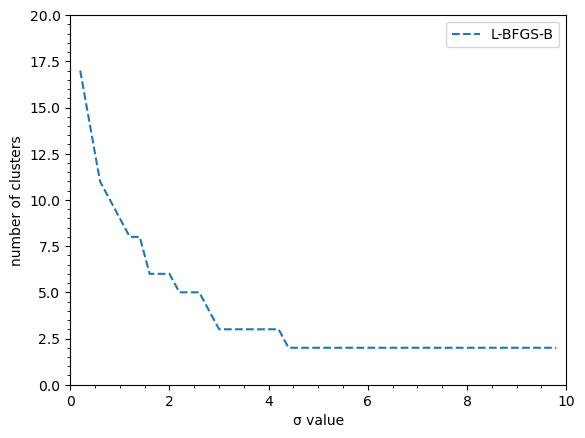

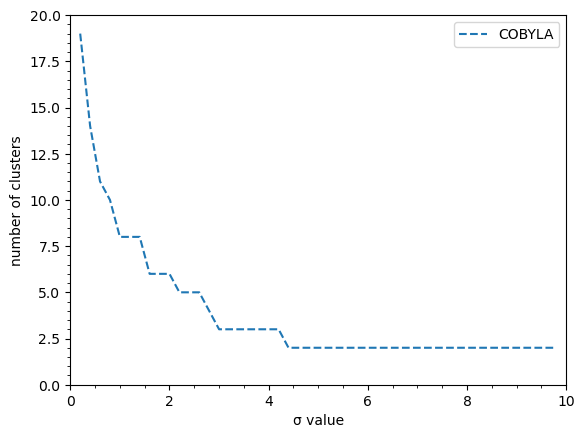

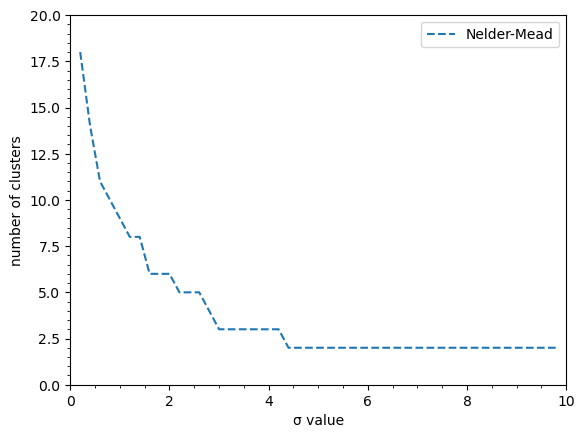

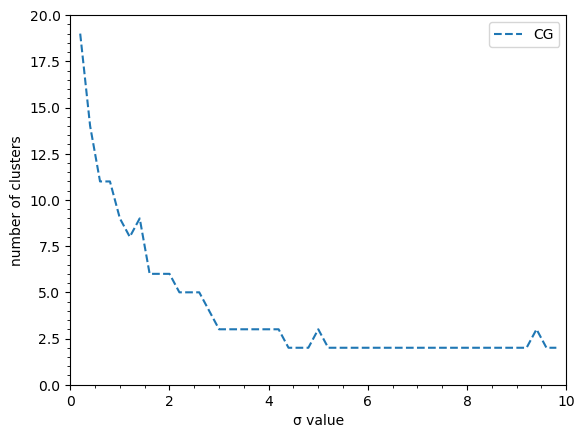

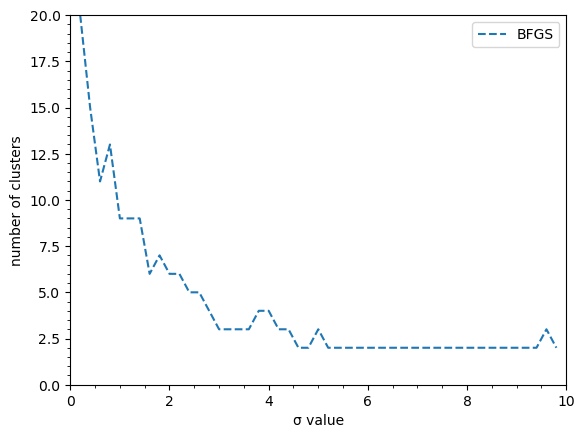

In [87]:
for my_method in list_method: # list_method=['SLSQP','L-BFGS-B','COBYLA','Nelder-Mead','CG','BFGS']
    plt.plot(list_sigma, list_numCat[my_method], '--', label=my_method)     
    plt.xlabel("σ value".format(i))
    plt.ylabel("number of clusters".format(j))
    plt.xlim(0,10)
    plt.ylim(0,20)
    plt.minorticks_on()
    plt.legend(loc='best')
    plt.savefig(f"results/kaggle-cancer_numClusters_vs_sigma_{my_method}_umap{component_for_x}-umap{component_for_y}.pdf")
    plt.show() 



## 3.4 Generating results for specific optimization method and sigma value (post-UMAP)

In [106]:
# Set the choice of components for the clustering 2-d plane
component_for_x=0
component_for_y=1

my_sigma=6.0
my_method='L-BFGS-B'  #'SLSQP','L-BFGS-B','COBYLA','Nelder-Mead','CG','BFGS'

df_copy_cancer=df_cancer.copy()
ans=df_copy_cancer.apply(lambda x: compute_min([x['umap_{}'.format(component_for_x)],x['umap_{}'.format(component_for_y)]],df_copy_cancer[['umap_{}'.format(component_for_x), 'umap_{}'.format(component_for_y)]].to_numpy(),my_sigma,my_method), axis=1)
for i in range(len(ans[0])):
    df_copy_cancer['min_f{}'.format(i+1)]=ans.str[i]

# using DBSCAN to find cluster labelling
X_train = df_copy_cancer[['min_f1', 'min_f2']]
clustering = DBSCAN(eps=1.0, min_samples=3).fit(X_train)
df_copy_cancer['recon_label']=clustering.labels_

df_copy_cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,symmetry_worst,fractal_dimension_worst,true_label,umap_0,umap_1,pca_0,pca_1,min_f1,min_f2,recon_label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,0.4601,0.11890,True,5.136652,3.198488,9.192837,1.948583,5.555954,4.077709,0
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,0.2750,0.08902,True,6.579583,4.346704,2.387802,-3.768172,5.555954,4.077714,0
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,0.3613,0.08758,True,5.505779,3.529454,5.733896,-1.075174,5.555959,4.077720,0
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,0.6638,0.17300,True,6.029747,1.613011,7.122953,10.275589,5.555956,4.077713,0
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,0.2364,0.07678,True,6.186091,4.971519,3.935302,-1.948072,5.555953,4.077715,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,0.2060,0.07115,True,4.940297,4.166133,6.439315,-3.576817,5.555954,4.077715,0
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,0.2572,0.06637,True,5.821593,4.803040,3.793382,-3.584048,5.555953,4.077716,0
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,0.2218,0.07820,True,8.984872,3.597478,1.256179,-1.902297,11.569423,1.557712,1
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,0.4087,0.12400,True,4.964241,3.189691,10.374794,1.672010,5.555954,4.077715,0


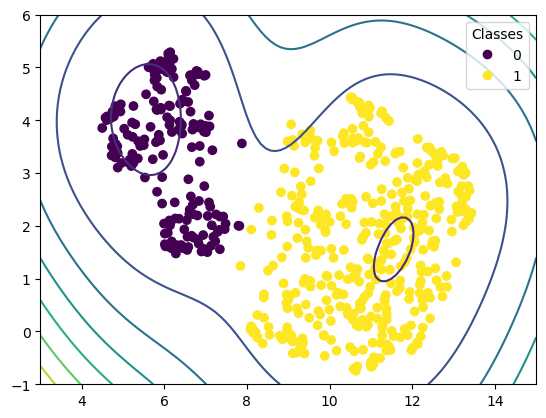

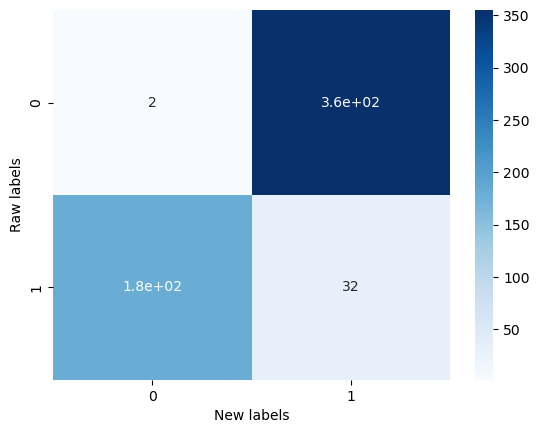

In [107]:
# plotting
x = np.linspace(3, 15, 100)
y = np.linspace(-1, 6, 100)
X,Y = meshgrid(x, y)
Z = np.array([[potential_eqn(np.array([i,j]), df_copy_cancer[['umap_{}'.format(component_for_x), 'umap_{}'.format(component_for_y)]].to_numpy(), my_sigma) for i in x] for j in y])

fig, ax = plt.subplots(1, 1) 
scatter = ax.scatter(df_copy_cancer['umap_{}'.format(component_for_x)].to_numpy(), df_copy_cancer['umap_{}'.format(component_for_y)].to_numpy(), c=df_copy_cancer['recon_label'].to_list())
ax.contour(X, Y, Z)
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
plt.savefig(f"results/kaggle-cancer_clustering-result_{my_method}_sigma{my_sigma}_umap{component_for_x}-umap{component_for_y}.pdf")
plt.show()

cf_matrix = confusion_matrix(df_copy_cancer['true_label'], df_copy_cancer['recon_label'])
ax= plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True)
ax.set_xlabel('New labels');ax.set_ylabel('Raw labels')
plt.savefig(f"results/kaggle-cancer_confusion-matrix_{my_method}_sigma{my_sigma}_umap{component_for_x}-umap{component_for_y}.pdf")
plt.show()